<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/028_PyTorch_Proj_TwentyEight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [ ]:
# utils
import numpy as np
import time
import os, sys
import json
import random
# google
from google.colab import drive
# torch
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Subset
# vis
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [ ]:
%matplotlib inline

In [ ]:
# python version
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [ ]:
# torch version
torch.__version__

'2.3.0+cu121'

In [ ]:
os.cpu_count()

2

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using gpu: %s " % torch.cuda.is_available())

Using gpu: True 


In [ ]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# curr dir
os.getcwd()

'/content'

In [ ]:
# working dir
main_dir = "/content/drive/MyDrive/DataSets/"
os.chdir(main_dir)
work_dir = "cats_vs_dogs"
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

In [ ]:
# !wget http://files.fast.ai/data/examples/dogscats.tgz
# !tar -zxvf dogscats.tgz

In [ ]:
os.chdir("dogscats")
os.listdir()

['test1',
 'imagenet_class_index.json',
 'imagenet_class_index.json.3',
 'imagenet_class_index.json.4',
 'imagenet_class_index.json.2',
 'imagenet_class_index.json.1',
 'valid',
 'sample',
 'train']

## Preprocessing

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
imagenet_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
                ])

In [ ]:
%%time
dsets = {x: datasets.ImageFolder(os.path.join("./", x), imagenet_format)
         for x in ['train', 'valid']}

CPU times: user 111 ms, sys: 10.5 ms, total: 121 ms
Wall time: 2.7 s


In [ ]:
dsets

{'train': Dataset ImageFolder
     Number of datapoints: 23000
     Root location: ./train
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 2000
     Root location: ./valid
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
n_samples = 5000
dsets["train"] = Subset(dsets["train"], range(n_samples))
dsets

{'train': <torch.utils.data.dataset.Subset at 0x7e8711b245b0>,
 'valid': Dataset ImageFolder
     Number of datapoints: 2000
     Root location: ./valid
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
dsets['valid'].classes

['cats', 'dogs']

In [ ]:
dsets['valid'].class_to_idx

{'cats': 0, 'dogs': 1}

In [ ]:
dsets['valid'].imgs[:5]

[('./valid/cats/cat.1001.jpg', 0),
 ('./valid/cats/cat.10016.jpg', 0),
 ('./valid/cats/cat.10026.jpg', 0),
 ('./valid/cats/cat.10048.jpg', 0),
 ('./valid/cats/cat.10050.jpg', 0)]

In [ ]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 5000, 'valid': 2000}

In [ ]:
dset_classes = dsets['valid'].classes
dset_classes

['cats', 'dogs']

In [ ]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
count = len(loader_valid)
count

400

In [ ]:
inputs_try, labels_try = next(iter(loader_valid))

In [ ]:
labels_try, inputs_try.shape

(tensor([0, 0, 0, 0, 0]), torch.Size([5, 3, 224, 224]))

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

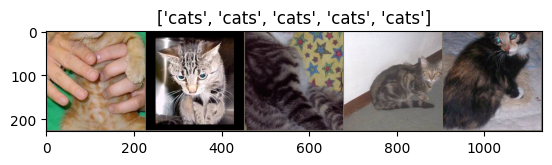

In [ ]:
out = torchvision.utils.make_grid(inputs_try)
imshow(out, title=[dset_classes[x] for x in labels_try])

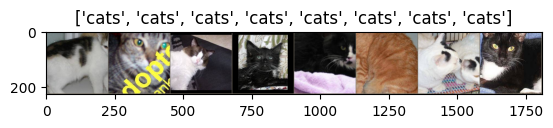

In [ ]:
inputs, classes = next(iter(loader_train))
n_images = 8
out = torchvision.utils.make_grid(inputs[0:n_images])
imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Pretrained Model

In [ ]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.9MB/s]


In [ ]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-05-24 18:49:47--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.176, 52.217.126.216, 54.231.202.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.4’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2024-05-24 18:49:48 (1.66 MB/s) - ‘imagenet_class_index.json.4’ saved [35363/35363]



In [ ]:
fpath = 'imagenet_class_index.json'
with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [ ]:
# dic_imagenet

In [ ]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_vgg = model_vgg.to(device)
outputs_try = model_vgg(inputs_try)
outputs_try

tensor([[ 0.2802, -0.7802, -1.2573,  ...,  2.6398,  3.6586,  0.7026],
        [-3.7224,  0.0391, -3.7282,  ..., -5.7824,  7.3879,  4.1145],
        [-2.3677, -2.3315, -2.8244,  ..., -2.6510,  2.1892,  3.1411],
        [-2.3831, -2.8609,  0.2242,  ..., -5.1053, -0.1229,  2.6799],
        [-5.4756, -1.6140, -4.8852,  ..., -5.5456,  2.7211,  5.8882]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try, preds_try = torch.max(probs, dim=1)

In [ ]:
torch.sum(probs, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [ ]:
vals_try

tensor([0.5198, 0.5864, 0.5179, 0.9164, 0.4131], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [ ]:
preds_try

tensor([333, 281, 281, 281, 283], device='cuda:0')

In [ ]:
print([dic_imagenet[i] for i in preds_try.data])

['hamster', 'tabby', 'tabby', 'tabby', 'Persian_cat']


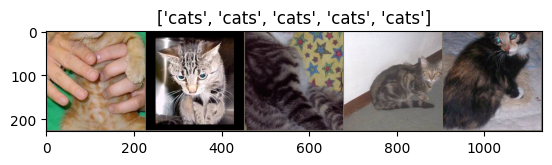

In [ ]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())
imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

## Modified VGG

In [ ]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for _ in model_vgg.named_children():
  print(_[0])

features
avgpool
classifier


In [ ]:
model_vgg.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [ ]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim=1)

In [ ]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


In [ ]:
model_vgg = model_vgg.to(device)

In [ ]:
for name, param in model_vgg.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, requires_grad={param.requires_grad}")

In [ ]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(), lr=lr)

In [ ]:
def train_model(model, dataloader, size, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs.data, 1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [ ]:
%%time
train_model(model_vgg,loader_train, size=dset_sizes['train'], epochs=5, optimizer=optimizer_vgg)

Loss: 0.0012 Acc: 0.9828
Loss: 0.0002 Acc: 1.0000
Loss: 0.0001 Acc: 1.0000
Loss: 0.0001 Acc: 1.0000
Loss: 0.0001 Acc: 1.0000
CPU times: user 1min 25s, sys: 7.92 s, total: 1min 33s
Wall time: 9min 14s


In [ ]:
def test_model(model, dataloader, size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs, classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, classes)
        _,preds = torch.max(outputs.data,1)
        # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

Loss: 0.3012 Acc: 0.5000


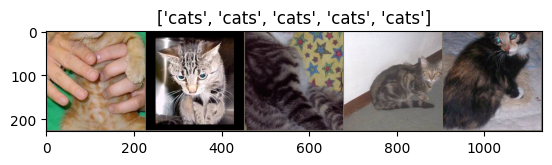

In [ ]:
inputs, classes = next(iter(loader_valid))
out = torchvision.utils.make_grid(inputs[0:n_images])
imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[9.8931e-01, 1.0689e-02],
        [9.9990e-01, 1.0020e-04],
        [9.9322e-01, 6.7769e-03],
        [9.9929e-01, 7.0942e-04],
        [9.9392e-01, 6.0769e-03]], device='cuda:0', grad_fn=<ExpBackward0>)


In [ ]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

## Precompute Features

In [ ]:
x_try = model_vgg.features(inputs_try)
x_try.shape

torch.Size([5, 512, 7, 7])

In [ ]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features, labels_list)

In [ ]:
%%time
conv_feat_train, labels_train = preconvfeat(loader_train)

CPU times: user 16.2 s, sys: 2.35 s, total: 18.5 s
Wall time: 31.5 s


In [ ]:
conv_feat_train.shape

(5000, 512, 7, 7)

In [ ]:
%%time
conv_feat_valid, labels_valid = preconvfeat(loader_valid)

CPU times: user 11.5 s, sys: 1.21 s, total: 12.7 s
Wall time: 17.5 s


## New Data Gen

In [ ]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype), torch.tensor(l).type(torch.long)] for (f, l) in zip(conv_feat_train, labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs, classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [ ]:
%%time
train_model(model_vgg.classifier, dataloader=loaderfeat_train, size=dset_sizes['train'], epochs=5, optimizer=optimizer_vgg)

Loss: 0.0000 Acc: 1.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0000 Acc: 1.0000
Loss: 0.0000 Acc: 1.0000
CPU times: user 2.29 s, sys: 15.1 ms, total: 2.31 s
Wall time: 2.31 s


In [ ]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid, labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier, dataloader=loaderfeat_valid, size=dset_sizes['valid'])

Loss: 0.0135 Acc: 0.5000


## Model Prediction

In [ ]:
n_view = 8
correct = np.where(predictions==all_classes)[0]
len(correct)/dset_sizes['valid']

0.5

In [ ]:
idx = np.random.permutation(correct)[:n_view]
idx

array([786, 644, 980, 729,  32, 275, 833, 704])

In [ ]:
loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx], batch_size=n_view, shuffle=True)
for data in loader_correct:
    inputs_cor,labels_cor = data

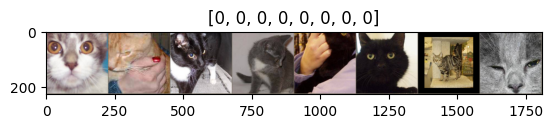

In [ ]:
out = torchvision.utils.make_grid(inputs_cor)
imshow(out, title=[l.item() for l in labels_cor])

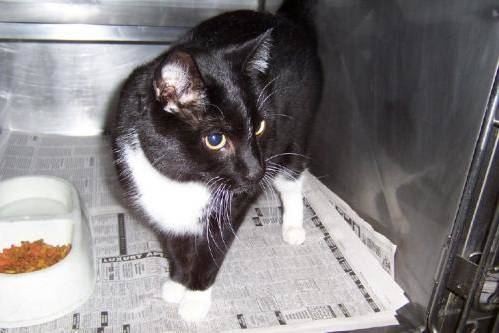

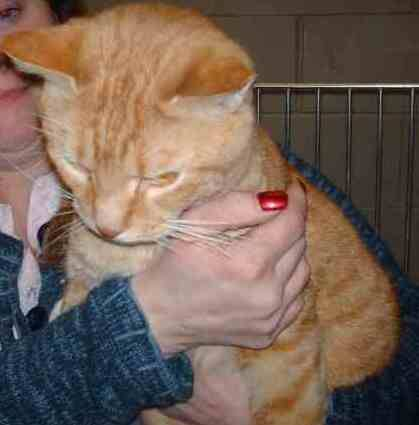

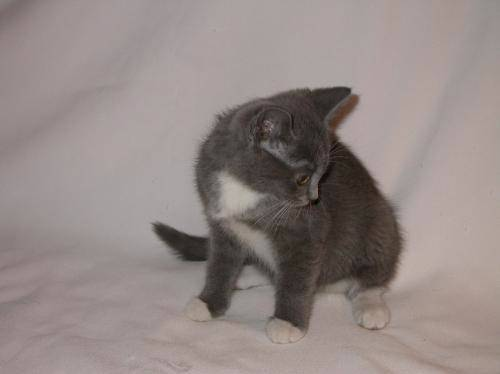

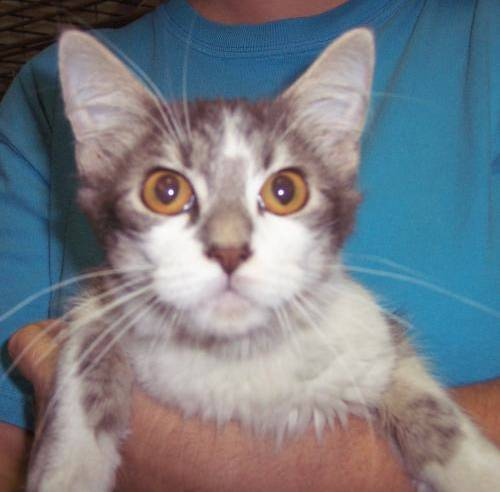

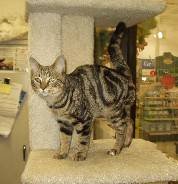

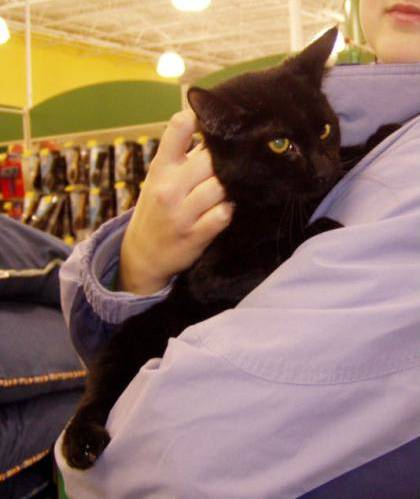

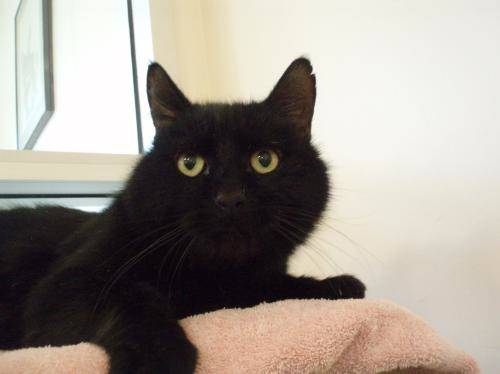

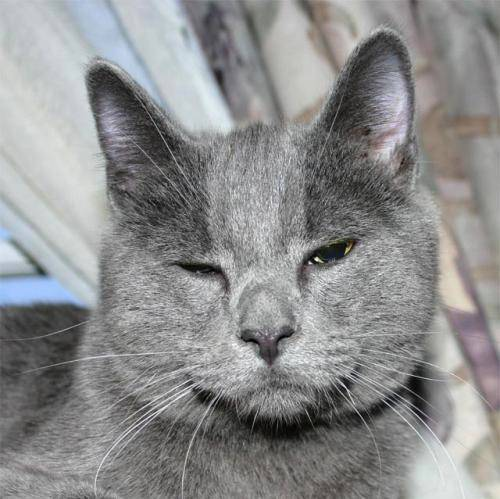

In [ ]:
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

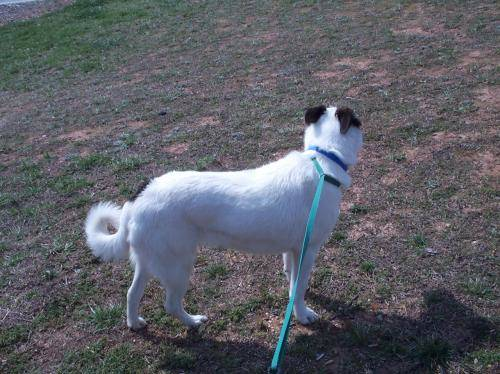

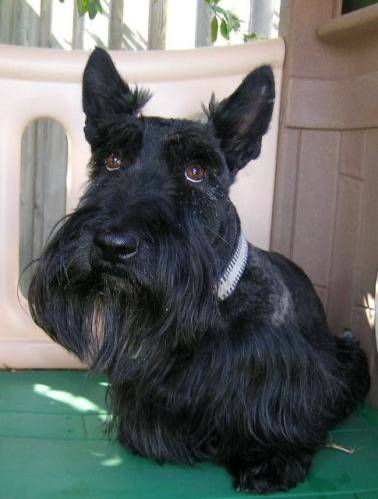

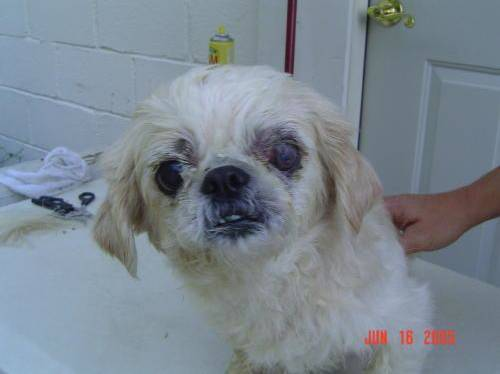

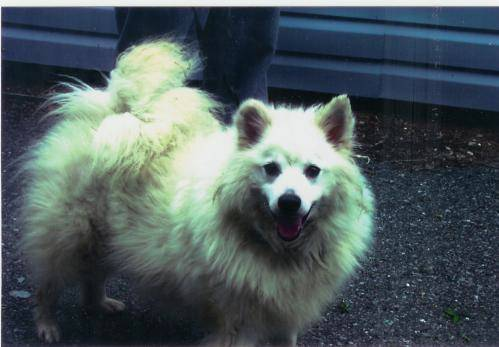

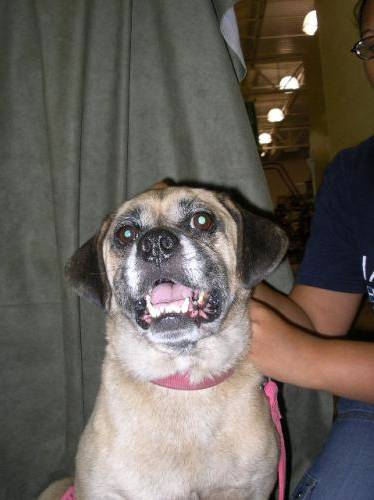

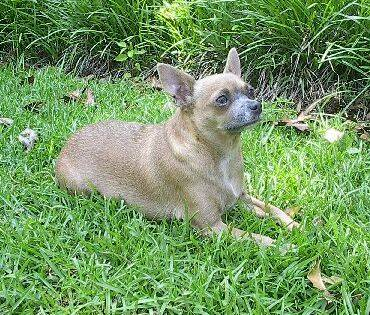

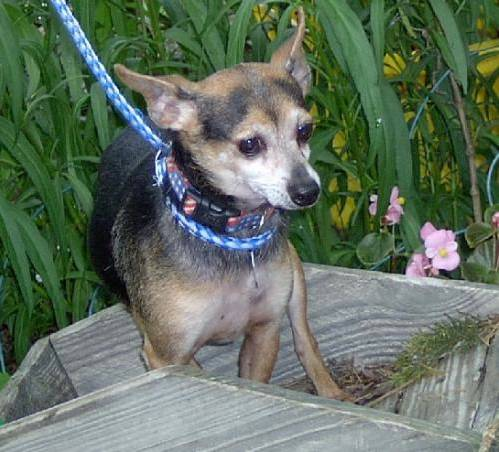

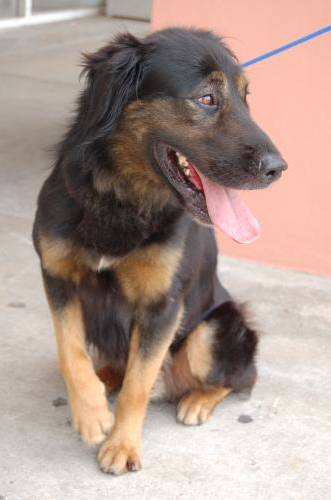

In [ ]:
incorrect = np.where(predictions!=all_classes)[0]
for x in np.random.permutation(incorrect)[:n_view]:
    #print(dsets['valid'].imgs[x][1])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [ ]:
correct_cats = np.where((predictions==0) & (predictions==all_classes))[0]
most_correct_cats = np.argsort(all_proba[correct_cats,1])[:n_view]

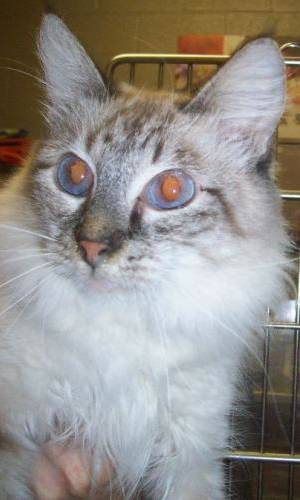

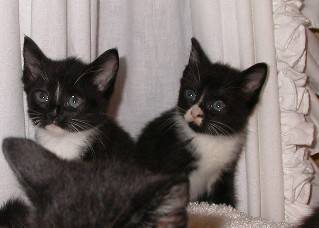

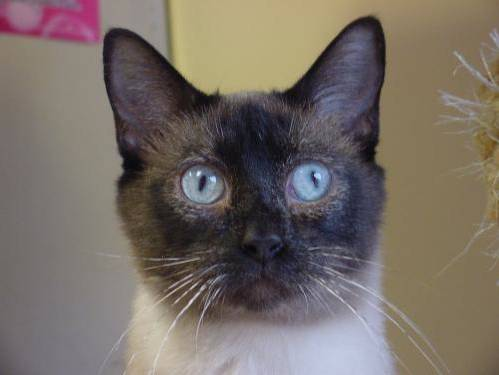

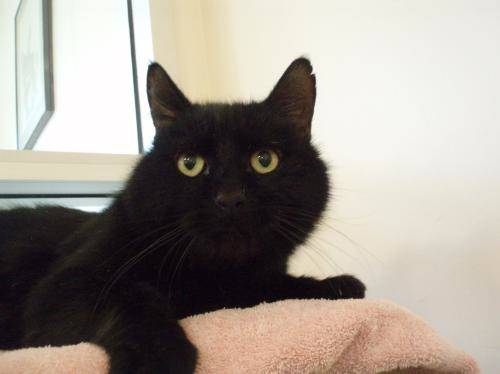

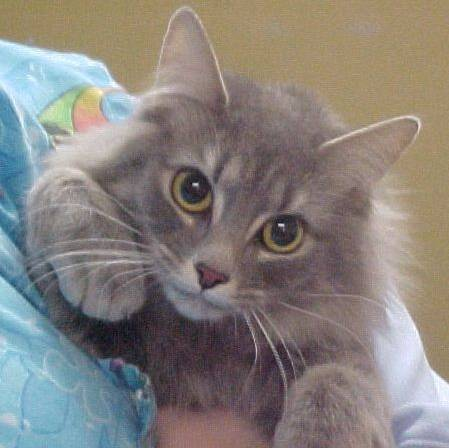

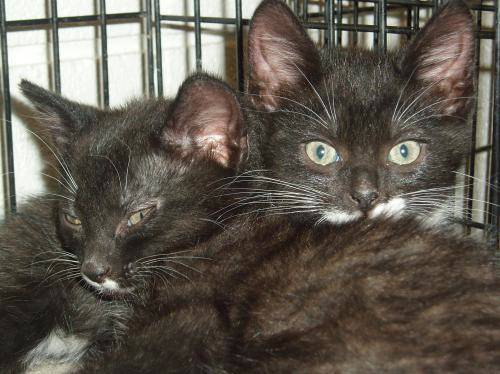

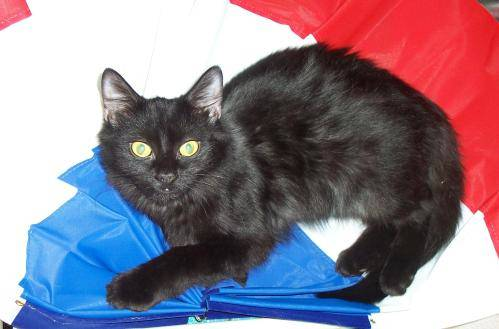

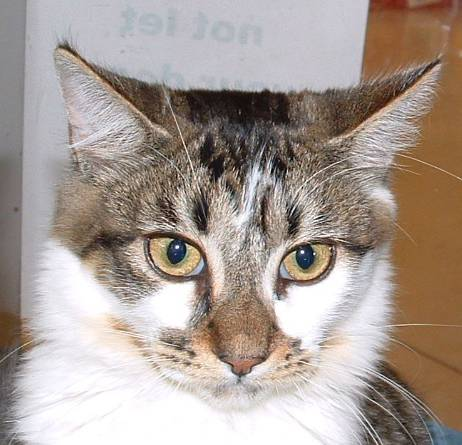

In [ ]:
for x in most_correct_cats:
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

In [ ]:
correct_dogs = np.where((predictions==1) & (predictions==all_classes))[0]
most_correct_dogs = np.argsort(all_proba[correct_dogs,0])[:n_view]

In [ ]:
for x in most_correct_dogs:
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))